Kết nối Mount đến Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Khai báo thư viện

In [3]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure

In [4]:
#Hàm load dữ liệu từ folder
def load_images_from_folder(folder, img_rows, img_cols):
    images = []
    labels = []
    class_names = sorted([
        d for d in os.listdir(folder)
        if os.path.isdir(os.path.join(folder, d))
    ])

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)

        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)

            # Bỏ qua file không phải ảnh
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (img_rows, img_cols))
            images.append(img)
            labels.append(label)

    return images, labels, class_names


In [5]:
import os
import numpy as np

# Đọc dữ liệu từ thư mục Dataset đã chia sẵn
base_data_path = "/content/drive/MyDrive/split_data"
img_rows, img_cols = 128, 128

# Load training data
print("Đang tải dữ liệu Training...")
X_train_list, y_train_list, class_names = load_images_from_folder(
    os.path.join(base_data_path, "train"), img_rows, img_cols
)
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
print(f"Số ảnh Training: {len(X_train)}")
print(f"Số label Training: {len(y_train)}")

# Load validation data
print("\nĐang tải dữ liệu Validation...")
X_val_list, y_val_list, _ = load_images_from_folder(
    os.path.join(base_data_path, "validation"), img_rows, img_cols
)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
print(f"Số ảnh Validation: {len(X_val)}")
print(f"Số label Validation: {len(y_val)}")

# Load test data
print("\nĐang tải dữ liệu Test...")
X_test_list, y_test_list, _ = load_images_from_folder(
    os.path.join(base_data_path, "test"), img_rows, img_cols
)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)
print(f"Số ảnh Test: {len(X_test)}")
print(f"Số label Test: {len(y_test)}")

print("\nTên lớp:", class_names)

Đang tải dữ liệu Training...
Số ảnh Training: 4471
Số label Training: 4471

Đang tải dữ liệu Validation...
Số ảnh Validation: 558
Số label Validation: 558

Đang tải dữ liệu Test...
Số ảnh Test: 558
Số label Test: 558

Tên lớp: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [6]:
#Trích xuất đặc trưng hog
def extract_hog_features(images):
    hog_features = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

        hog_features.append(features)

    return np.array(hog_features)

In [7]:
X_train_hog = extract_hog_features(X_train)
X_val_hog   = extract_hog_features(X_val)
X_test_hog  = extract_hog_features(X_test)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_val_hog_scaled = scaler.transform(X_val_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

Để tối ưu hóa hiệu suất của mô hình SVM, chúng ta có thể sử dụng `GridSearchCV` để tìm kiếm các siêu tham số tốt nhất. Các siêu tham số sẽ được điều chỉnh là `C` (tham số điều chỉnh lỗi) và `kernel` (hàm nhân).

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC # Thêm import SVC tại đây

# Định nghĩa lưới tham số cho GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search.fit(X_train_hog_scaled, y_train)

print("Các tham số tốt nhất: ", grid_search.best_params_)
print("Điểm số tốt nhất: ", grid_search.best_score_)

# Lấy mô hình tốt nhất
best_svm_model = grid_search.best_estimator_

# Đánh giá mô hình tốt nhất trên tập kiểm tra
y_pred_best = best_svm_model.predict(X_test_hog_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Độ chính xác của mô hình tốt nhất trên tập kiểm tra: {accuracy_best:.4f}")

print("Báo cáo phân loại của mô hình tốt nhất:")
print(classification_report(y_test, y_pred_best, target_names=class_names))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Các tham số tốt nhất:  {'C': 10, 'kernel': 'rbf'}
Điểm số tốt nhất:  0.8009376167519658
Độ chính xác của mô hình tốt nhất trên tập kiểm tra: 0.8208
Báo cáo phân loại của mô hình tốt nhất:
                precision    recall  f1-score   support

Auto Rickshaws       0.84      0.78      0.81        80
         Bikes       0.95      0.93      0.94        80
          Cars       0.82      0.78      0.80        79
   Motorcycles       0.78      0.85      0.81        80
        Planes       0.82      0.81      0.82        79
         Ships       0.80      0.86      0.83        80
        Trains       0.75      0.74      0.74        80

      accuracy                           0.82       558
     macro avg       0.82      0.82      0.82       558
  weighted avg       0.82      0.82      0.82       558



In [16]:
# Per class accuracy
cm_best = confusion_matrix(y_test, y_pred_best)
per_class_accuracy = cm_best.diagonal() / cm_best.sum(axis=1)
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_accuracy[idx]:.4f}")

Auto Rickshaws: 0.7750
Bikes: 0.9250
Cars: 0.7848
Motorcycles: 0.8500
Planes: 0.8101
Ships: 0.8625
Trains: 0.7375


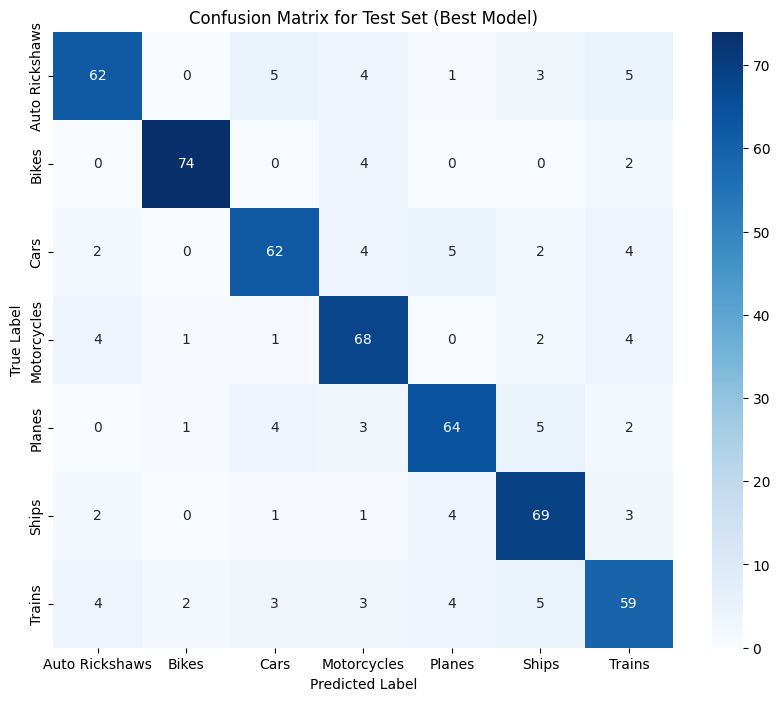

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tính toán ma trận nhầm lẫn cho tập kiểm tra
cm_test = confusion_matrix(y_test, y_pred_best)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set (Best Model)')
plt.show()

Các dự đoán sai:


,Index,True Class,Predicted Class
0,1,Auto Rickshaws,Cars
1,10,Auto Rickshaws,Cars
2,15,Auto Rickshaws,Motorcycles
3,16,Auto Rickshaws,Trains
4,17,Auto Rickshaws,Ships
...,...,...,...
95,537,Trains,Auto Rickshaws
96,540,Trains,Motorcycles
97,547,Trains,Bikes
98,554,Trains,Bikes


Tổng số mẫu bị phân loại sai: 100

Thống kê các lỗi phân loại:


,True Class,Predicted Class,Count
0,Auto Rickshaws,Cars,5
4,Auto Rickshaws,Trains,5
9,Cars,Planes,5
32,Trains,Ships,5
20,Planes,Ships,5
16,Motorcycles,Trains,4
12,Motorcycles,Auto Rickshaws,4
8,Cars,Motorcycles,4
1,Auto Rickshaws,Motorcycles,4
18,Planes,Cars,4



Hiển thị hình ảnh bị phân loại sai và nhãn của chúng:


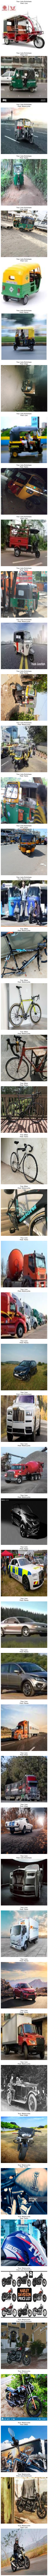

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

misclassified_samples = []

y_test_pred = best_svm_model.predict(X_test_hog_scaled)

for i in range(len(y_test)):
    if y_test[i] != y_test_pred[i]:
        true_class_name = class_names[y_test[i]]
        predicted_class_name = class_names[y_test_pred[i]]
        misclassified_samples.append({
            'Index': i,
            'True Class': true_class_name,
            'Predicted Class': predicted_class_name
        })

misclassified_df = pd.DataFrame(misclassified_samples)

if not misclassified_df.empty:
    print("Các dự đoán sai:")
    display(misclassified_df)
    print(f"Tổng số mẫu bị phân loại sai: {len(misclassified_df)}")

    print("\nThống kê các lỗi phân loại:")
    misclassification_counts = misclassified_df.groupby(['True Class', 'Predicted Class']).size().reset_index(name='Count')
    display(misclassification_counts.sort_values(by='Count', ascending=False).head(10))

    print("\nHiển thị hình ảnh bị phân loại sai và nhãn của chúng:")

    num_images_to_show = min(50, len(misclassified_df)) # Limit for display purposes

    cols = 1 # Only one column for the image
    rows = num_images_to_show

    plt.figure(figsize=(8, 6 * rows))

    for j in range(num_images_to_show):
        sample_info = misclassified_df.iloc[j]
        img_idx = sample_info['Index']
        true_label = sample_info['True Class']
        predicted_label = sample_info['Predicted Class']

        # Lấy hình ảnh gốc từ X_test
        image_to_show = X_test[img_idx]
        image_to_show_rgb = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)

        # Plot original image
        ax1 = plt.subplot(rows, cols, j + 1)
        ax1.imshow(image_to_show_rgb)
        ax1.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax1.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Không có dự đoán sai nào.")

Sử dụng mô hình tốt nhất để dự đoán một hình ảnh mới

In [19]:
# Hàm để tải và tiền xử lý một hình ảnh mới
def preprocess_new_image(image_path, img_rows, img_cols, scaler, hog_feature_extractor):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Không thể tải hình ảnh từ: {image_path}")
        return None

    img = cv2.resize(img, (img_rows, img_cols))
    img = np.expand_dims(img, axis=0) # Thêm chiều batch

    # Trích xuất đặc trưng HOG
    hog_features = hog_feature_extractor(img)

    # Chuẩn hóa đặc trưng
    hog_features_scaled = scaler.transform(hog_features)
    return hog_features_scaled


In [20]:
from google.colab import files
import io

# Tải ảnh lên từ máy tính của bạn
uploaded = files.upload()

# Lấy tên file đã tải lên
for filename in uploaded.keys():
    new_image_path = filename
    # Lưu file vào một vị trí tạm thời để cv2 có thể đọc được
    with open(new_image_path, 'wb') as f:
        f.write(uploaded[filename])
    print(f"File '{filename}' đã được tải lên thành công.")
    break # Chỉ xử lý file đầu tiên nếu có nhiều file được tải lên

Saving images.jpg to images.jpg
File 'images.jpg' đã được tải lên thành công.


In [21]:
# Tiền xử lý hình ảnh mới
new_image_hog_scaled = preprocess_new_image(
    new_image_path, img_rows, img_cols, scaler, extract_hog_features
)

if new_image_hog_scaled is not None:
    # Dự đoán lớp của hình ảnh mới
    prediction = best_svm_model.predict(new_image_hog_scaled)
    predicted_class_idx = prediction[0]
    predicted_class_name = class_names[predicted_class_idx]

    print(f"Hình ảnh dự đoán là: {predicted_class_name}")
else:
    print("Không thể dự đoán do lỗi tải hoặc tiền xử lý hình ảnh.")

Hình ảnh dự đoán là: Bikes
